In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("model_db.csv")
df

,home_team,away_team,target,rank_dif,goals_dif,goals_dif_l5,goals_suf_dif,goals_suf_dif_l5,goals_per_ranking_dif,dif_rank_agst,dif_rank_agst_l5,dif_points_rank,dif_points_rank_l5,is_friendly_0,is_friendly_1
0,Barbados,Cuba,1,-21.0,2.000000,2.0,1.000000,1.0,0.037037,-92.000000,-92.0,0.018519,0.018519,0,1
1,Barbados,Cuba,1,-21.0,1.000000,1.0,0.500000,0.5,0.008511,-35.500000,-35.5,0.008897,0.008897,0,1
2,Mongolia,Guam,1,-4.0,4.000000,4.0,-1.000000,-1.0,0.021622,0.000000,0.0,0.016216,0.016216,1,0
3,Nepal,Bhutan,0,-22.0,1.000000,1.0,0.000000,0.0,0.004975,7.000000,7.0,0.000000,0.000000,1,0
4,Bangladesh,Pakistan,0,-7.0,-1.000000,-1.0,-0.500000,-0.5,-0.007200,30.500000,30.5,-0.010437,-0.010437,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,Albania,Iceland,1,3.0,-0.002439,-0.8,-0.584878,0.0,-0.005083,21.632683,-14.8,-0.016141,-0.014533,1,0
3196,Norway,Serbia,1,11.0,-0.038095,-0.8,-0.230159,0.0,-0.005282,9.014286,-3.4,-0.011343,0.016348,1,0
3197,Sweden,Slovenia,1,-45.0,0.030812,0.2,0.137255,0.2,0.009459,-25.102241,10.2,0.022485,-0.020314,1,0
3198,Kosovo,Cyprus,0,-2.0,0.667341,0.6,-0.463094,0.0,0.007625,7.037917,1.6,0.008791,-0.002827,1,0


In [3]:
X = df.iloc[:, 3:]
y = df[["target"]]

In [4]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)

In [6]:
gb = GradientBoostingClassifier(random_state=5)

params = {"learning_rate": [0.01, 0.1, 0.5],
            "min_samples_split": [5, 10],
            "min_samples_leaf": [3, 5],
            "max_depth":[3,5,10],
            "max_features":["sqrt"],
            "n_estimators":[100, 200]
         } 

gb_cv = GridSearchCV(gb, params, cv = 3, n_jobs = -1, verbose = 20)

gb_cv.fit(X_train, np.ravel(y_train))

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=5),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 10], 'max_features': ['sqrt'],
                         'min_samples_leaf': [3, 5],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 200]},
             verbose=20)

In [7]:
gb_cv.best_estimator_

GradientBoostingClassifier(learning_rate=0.01, max_features='sqrt',
                           min_samples_leaf=3, min_samples_split=5,
                           n_estimators=200, random_state=5)

In [8]:
gb = gb_cv.best_estimator_

In [9]:
params_rf = {"max_depth": [20],
                "min_samples_split": [10],
                "max_leaf_nodes": [175],
                "min_samples_leaf": [5],
                "n_estimators": [250],
                 "max_features": ["sqrt"],
                }

rf = RandomForestClassifier(random_state=1)

rf_cv = GridSearchCV(rf, params_rf, cv = 3, n_jobs = -1, verbose = False)

rf_cv.fit(X_train.values, np.ravel(y_train))

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [20], 'max_features': ['sqrt'],
                         'max_leaf_nodes': [175], 'min_samples_leaf': [5],
                         'min_samples_split': [10], 'n_estimators': [250]},
             verbose=False)

In [10]:
rf = rf_cv.best_estimator_

In [11]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score


In [12]:
def analyze(model):
    # Set custom colors for the graphs
    color_test = 'blue'
    color_train = 'green'

    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test.values)[:, 1])  # test AUC
    plt.figure(figsize=(15, 8))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, color=color_test, label="test")


    fpr_train, tpr_train, _ = roc_curve(y_train, model.predict_proba(X_train.values)[:, 1])  # train AUC
    plt.plot(fpr_train, tpr_train, color=color_train, label="train")
    auc_test = roc_auc_score(y_test, model.predict_proba(X_test.values)[:, 1])
    auc_train = roc_auc_score(y_train, model.predict_proba(X_train.values)[:, 1])
    plt.legend()
    plt.title('AUC score is %.2f on test and %.2f on training' % (auc_test, auc_train))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(13, 10))
    cm = confusion_matrix(y_test, model.predict(X_test.values))
    sns.heatmap(cm, annot=True, fmt="d", cmap="BuGn_r")
    plt.title('Confusion Matrix')
    plt.show()


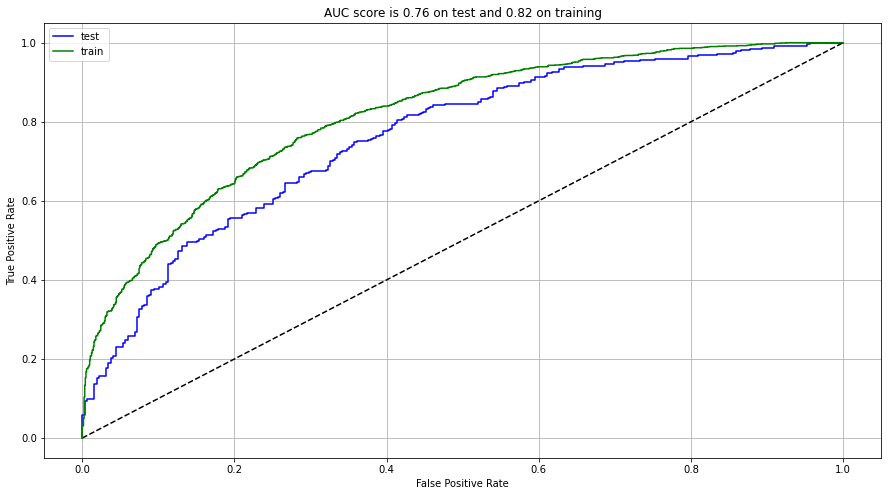

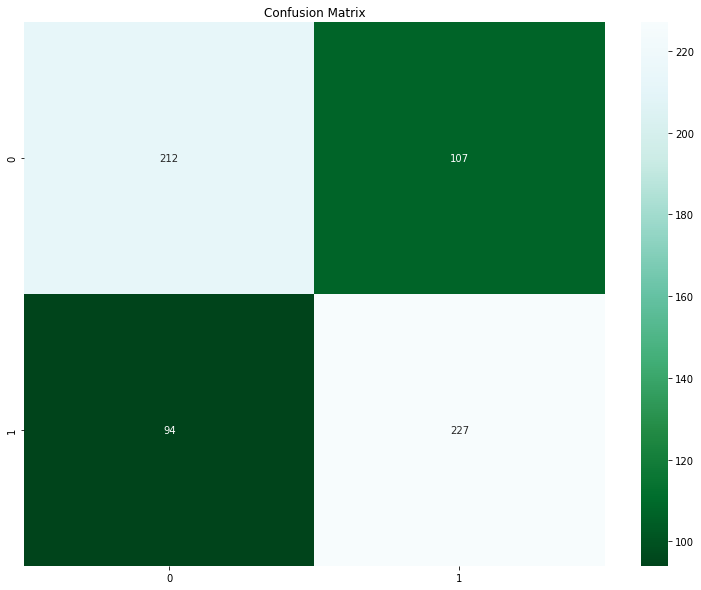

In [13]:
analyze(gb)

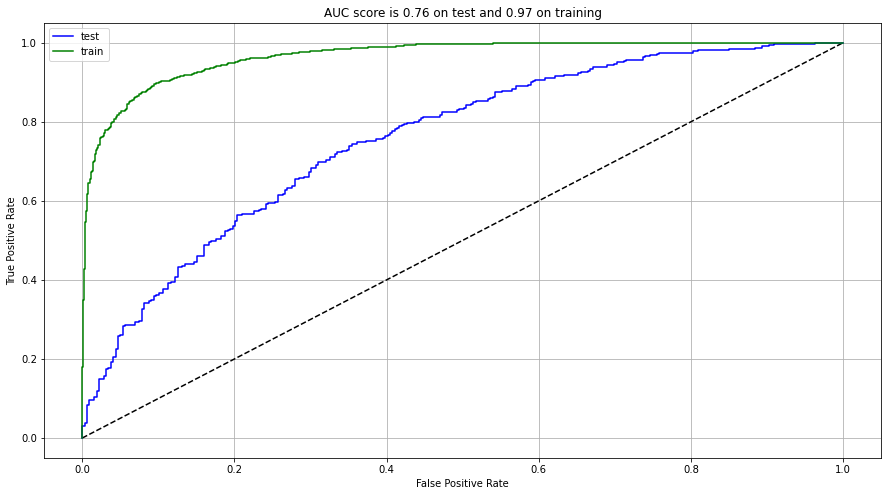

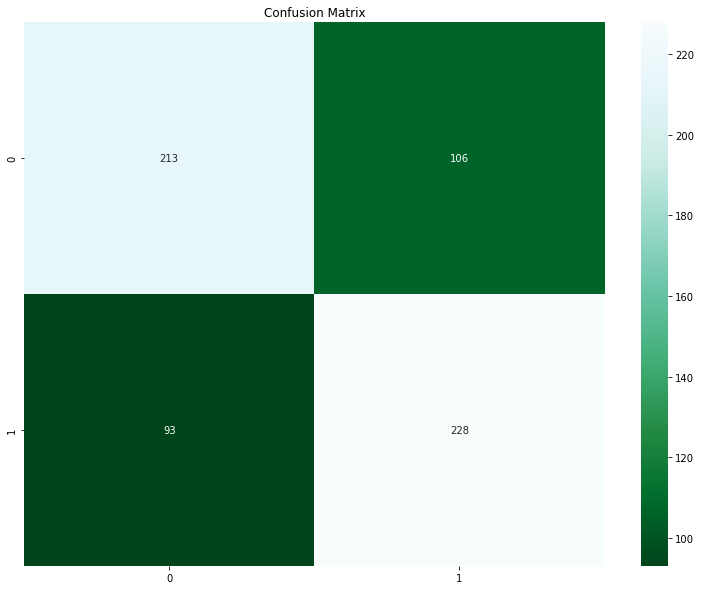

[CV 1/3; 3/72] START learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=100
[CV 1/3; 3/72] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=100;, score=0.714 total time=   0.2s
[CV 3/3; 4/72] START learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=200
[CV 3/3; 4/72] END learning_rate=0.01, max_depth=3, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=200;, score=0.712 total time=   0.7s
[CV 2/3; 9/72] START learning_rate=0.01, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=100
[CV 2/3; 9/72] END learning_rate=0.01, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=5, n_estimators=100;, score=0.695 total time=   0.3s
[CV 1/3; 12/72] START learning_rate=0.01, max_depth=5, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n

In [14]:
analyze(rf)